# CNN

## Notebook's Environment

In [1]:
INSTALL_DEPS = True
if INSTALL_DEPS:
  %pip install hurst==0.0.5
  %pip install imbalanced_learn==0.12.3
  %pip install imblearn==0.0
  %pip install protobuf==5.27.0
  %pip install pykalman==0.9.7
  %pip install tqdm==4.66.4

!python --version

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached protobuf-5.27.0-cp38-abi3-manylinux2014_x86_64.whl.metadata (592 bytes)
Using cached protobuf-5.27.0-cp38-abi3-manylinux2014_x86_64.whl (309 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 24.4.1 requires cubinlinker, which is not installed.
cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 24.4.1 requires ptxcompiler, which is not installed.
cuml 24.4.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 24.4.1 requires cupy-cuda11x>=12.0.0, which 

## Cloud Environment Setup

In [2]:
import os
import sys
import warnings

warnings.filterwarnings("ignore")

IN_KAGGLE = IN_COLAB = False
try:
    # https://www.tensorflow.org/install/pip#windows-wsl2
    import google.colab
    from google.colab import drive

    drive.mount("/content/drive")
    DATA_PATH = "/content/drive/MyDrive/EDT dataset"
    MODEL_PATH = "/content/drive/MyDrive/models"
    IN_COLAB = True
    print("Colab!")
except:
    IN_COLAB = False
if "KAGGLE_KERNEL_RUN_TYPE" in os.environ and not IN_COLAB:
    print("Running in Kaggle...")
    for dirname, _, filenames in os.walk("/kaggle/input"):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    MODEL_PATH = "./models"
    DATA_PATH = "/kaggle/input/intra-day-agriculture-futures-trades-2023-2024"
    IN_KAGGLE = True
    print("Kaggle!")
elif not IN_COLAB:
    IN_KAGGLE = False
    MODEL_PATH = "./models"
    DATA_PATH = "./data/"
    print("running localhost!")

Running in Kaggle...
/kaggle/input/intra-day-agriculture-futures-trades-2023-2024/futures_15m.csv
Kaggle!


In [3]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(f'Tensorflow version: [{tf.__version__}]')

tf.get_logger().setLevel('INFO')

#tf.config.set_soft_device_placement(True)
#tf.config.experimental.enable_op_determinism()
#tf.random.set_seed(1)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
except Exception as e:
  gpus = tf.config.experimental.list_physical_devices('GPU')
  if len(gpus) > 0:
    try:
        strategy = tf.distribute.MirroredStrategy()
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
    finally:
        print("Running on", len(tf.config.list_physical_devices('GPU')), "GPU(s)")
  else:
    # CPU is final fallback
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

def is_tpu_strategy(strategy):
    return isinstance(strategy, tf.distribute.TPUStrategy)

print("Number of accelerators:", strategy.num_replicas_in_sync)
os.getcwd()

2024-05-31 12:11:20.138237: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 12:11:20.138288: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 12:11:20.139863: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version: [2.15.0]
1 Physical GPUs, 1 Logical GPUs
Physical devices cannot be modified after being initialized
Running on 1 GPU(s)
Number of accelerators: 1


'/kaggle/working'

# Instruments

## Data Load

In [4]:
import pandas as pd
import numpy as np
from algo_trading_utility_script import *

filename = f"{DATA_PATH}{os.sep}futures_{INTERVAL}.csv"
print(filename)
futs_df = pd.read_csv(filename, index_col="Date", parse_dates=True)

print(futs_df.shape)

HALF_LIFE, HURST = get_ou(futs_df, f'{TARGET_FUT}_Close')

print("Half-Life:", HALF_LIFE)
print("Hurst:", HURST)

futs_df.head(2)

/kaggle/input/intra-day-agriculture-futures-trades-2023-2024/futures_15m.csv
(4688, 128)
Half-Life: 402
Hurst: 0.4924908823368806


,10Y_Open,10Y_High,10Y_Low,10Y_Close,10Y_Volume,10Y_Barcount,10Y_Average,10Y_Spread,2YY_Open,2YY_High,...,ZS_Average,ZS_Spread,ZW_Open,ZW_High,ZW_Low,ZW_Close,ZW_Volume,ZW_Barcount,ZW_Average,ZW_Spread
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-01 15:30:00+00:00,3.587,3.587,3.574,3.580,191.0,55.0,3.579749,0.013,4.167,4.179,...,1188.444270,9.25,600.5,605.0,600.00,604.5,7203.0,2296.0,602.673732,5.00
2023-06-01 15:45:00+00:00,3.583,3.588,3.581,3.583,42.0,22.0,3.584048,0.007,4.173,4.173,...,1191.678377,3.00,604.5,607.5,602.75,605.0,4481.0,1411.0,605.502724,4.75


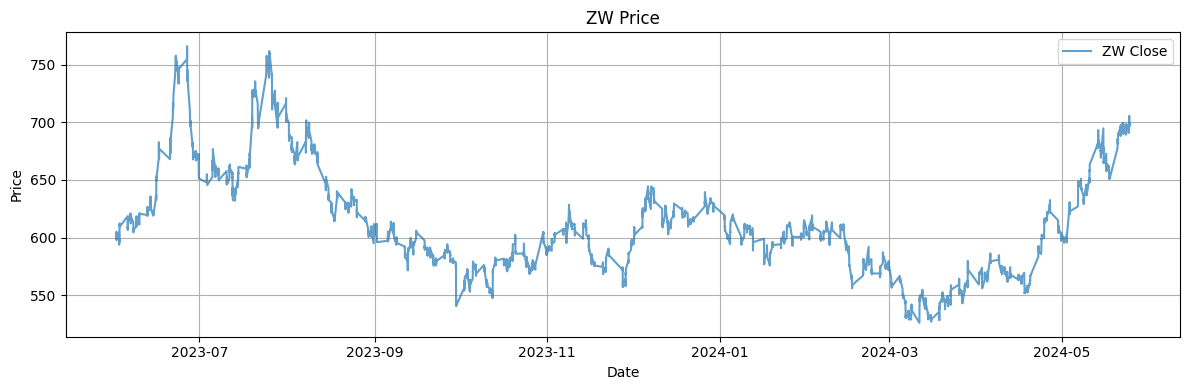

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(futs_df[f'{TARGET_FUT}_Close'], label=f'{TARGET_FUT} Close', alpha=0.7)
plt.title(f'{TARGET_FUT} Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Prepare the Data

In [6]:
import pickle
from tqdm import tqdm

from sklearn.preprocessing import normalize

TEST_SPLIT = 0.8
TRAIN_SIZE = int(len(futs_df) * TEST_SPLIT)
CACHE = True
FUTURES_TMP_FILE = "./tmp/futures.pkl"
os.makedirs("./tmp/", exist_ok=True)

def oversample_mean_reversions(train_agri_ts, window, period=INTERVAL, hurst=HURST):
    samples = []
    for df in tqdm(train_agri_ts, desc="oversample_mean_reversions"):
        bb_df = df.copy()
        results_df = param_search_bbs(bb_df, StockFeatExt.CLOSE, period, initial_window=window * 2, window_min=window // 2, hurst=hurst)
        results_df = results_df[results_df["Metric"] == "Sharpe"]
        bb_df, _ = bollinger_band_backtest(bb_df, StockFeatExt.CLOSE, results_df["Window"].iloc[0], period, std_factor=results_df["Standard_Factor"].iloc[0])

        samples.append(bb_df[train_agri_ts[0].columns].reset_index(drop=True))
    return train_agri_ts + samples

def normalize_and_label_data(ts, meta_label=META_LABEL, cols_to_scale=COLS_TO_SCALE):
    y0 = 0
    y1 = 0
    process_data = []
    for df in tqdm(ts, desc="label_data"):
        df = aug_metalabel_mr(df)
        y0  += (df[meta_label] == 0).sum()
        y1  += (df[meta_label] > 0).sum()

        if cols_to_scale is not None:
            aug_df_scaled = normalize(df[cols_to_scale])
            aug_df_scaled = pd.DataFrame(aug_df_scaled, columns=cols_to_scale)
            df[cols_to_scale] = aug_df_scaled
            df = df.loc[:, ~df.columns.duplicated(keep="first")]

        process_data.append(df)

    total = y0 + y1
    class_weight_0 = total / y0 if y0 != 0 else 0
    class_weight_1 = total / y1 if y1 != 0 else 0
    class_weights = {0: class_weight_0, 1: class_weight_1}

    return process_data, class_weights

with strategy.scope():
    if not os.path.exists(FUTURES_TMP_FILE):
        futs_exog_df = process_exog(MARKET_FUTS, futs_df)
        train_agri_ts, val_agri_ts = process_futures(FUTS, futs_df, futs_exog_df, TRAIN_SIZE, INTERVAL)
        train_agri_ts = oversample_mean_reversions(train_agri_ts, HALF_LIFE)
        val_agri_ts = oversample_mean_reversions(val_agri_ts, HALF_LIFE)

        if CACHE:
            with open(FUTURES_TMP_FILE, 'wb') as f:
                pickle.dump((train_agri_ts, val_agri_ts), f)
    else:
        with open(FUTURES_TMP_FILE, 'rb') as f:
            train_agri_ts, val_agri_ts = pickle.load(f)

train_agri_ts, CLASS_WEIGHTS = normalize_and_label_data(train_agri_ts)
val_agri_ts, val_weights = normalize_and_label_data(val_agri_ts)

print(f"train: {CLASS_WEIGHTS}")
print(f"test: {val_weights}")
np.shape(train_agri_ts)

label_data: 100%|██████████| 32/32 [00:01<00:00, 16.68it/s]


train: {0: 1.145267658595711, 1: 7.883844688259641}
test: {0: 1.1402955590168293, 1: 8.127809369076632}


(32, 3750, 92)

In [7]:
FEATURES = KF_COLS + BB_COLS + MOM_COLS + StockFeatExt.list

sample = val_agri_ts[0]
print(sample[META_LABEL].value_counts())

sampled_pattenrs = sample[sample[META_LABEL] > 0]
sampled_pattenrs[FEATURES + [META_LABEL, "Ret"]].tail(10)

mr_label
0    870
1     68
Name: count, dtype: int64


,SD,Z1,Z2,Filtered_X,KG_X,KG_Z1,KG_Z2,MA,U,L,...,Open,High,Low,Close,Volume,Spread,Barcount,Average,mr_label,Ret
889,1.318493,-0.079138,-0.023582,0.596026,0.454594,0.315953,0.096059,0.122042,0.122750,0.121334,...,0.122281,0.122414,0.122016,0.122149,0.910346,0.000398,0.147746,0.122261,1,0.000000
890,1.350747,-0.177480,-0.046835,0.400537,0.456067,0.326087,0.101426,0.095185,0.095752,0.094619,...,0.095309,0.095309,0.094947,0.095050,0.942946,0.000362,0.141773,0.095143,1,0.003256
900,1.511702,0.395189,0.144185,1.047033,0.460296,0.342767,0.109739,0.030192,0.030392,0.029992,...,0.030252,0.030465,0.030252,0.030465,0.987602,0.000212,0.124405,0.030378,1,0.000000
901,1.544781,0.157911,0.020137,1.016044,0.428749,0.328240,0.106740,0.062040,0.062459,0.061621,...,0.062501,0.062501,0.062334,0.062334,0.971471,0.000168,0.132443,0.062404,1,0.000000
902,1.572911,0.035161,-0.024182,0.982006,0.457009,0.323242,0.100260,0.060171,0.060584,0.059757,...,0.060408,0.060635,0.060408,0.060538,0.970165,0.000227,0.149706,0.060528,1,0.000000
903,1.601889,-0.155872,-0.077128,0.775564,0.457909,0.332892,0.105634,0.056443,0.056837,0.056048,...,0.056749,0.056870,0.056596,0.056627,0.974799,0.000274,0.133397,0.056755,1,0.000000
904,1.592010,-0.070602,-0.024757,0.796615,0.453787,0.341989,0.110285,0.067824,0.068295,0.067353,...,0.067925,0.068218,0.067743,0.068145,0.963957,0.000475,0.157324,0.067955,1,0.000000
905,1.546592,-0.119495,-0.032506,0.681455,0.452609,0.339478,0.108981,0.084034,0.084601,0.083468,...,0.084368,0.084413,0.084051,0.084232,0.949837,0.000362,0.164757,0.084264,1,0.000000
906,1.430288,-0.138008,-0.028027,0.564553,0.441169,0.327552,0.104835,0.125424,0.126205,0.124642,...,0.125600,0.125802,0.125532,0.125532,0.907124,0.000270,0.141114,0.125674,1,0.000000
907,1.441189,-0.141129,-0.020215,0.447308,0.457496,0.327639,0.102773,0.089725,0.090289,0.089162,...,0.089818,0.089866,0.089625,0.089673,0.949821,0.000241,0.132241,0.089765,1,0.004287


In [8]:
WINDOW = 8
WINDOW_TMP_PATH = "./tmp/"
# TPU see: https://github.com/tensorflow/tensorflow/issues/41635
BATCH_SIZE = 8  * strategy.num_replicas_in_sync # Default 8
print(f"BATCH_SIZE: {BATCH_SIZE}")

def prepare_windows(data_df, label_df, window_size=WINDOW):
    """
    Prepare windows of features and corresponding labels for classification.

    Parameters:
    - data_df: DataFrame containing the features.
    - label_df: DataFrame containing the labels.
    - window_size: The size of the input window.

    Returns:
    - X: Array of input windows.
    - y: Array of corresponding labels.
    """
    X, y = [], []
    for i in range(len(data_df) - window_size):
        input_window = data_df.iloc[i : i + window_size].values
        assert not np.isnan(input_window).any(), "NaN values found in input window"
        X.append(input_window)
        if label_df is not None:
            target_label = label_df.iloc[i + window_size]
            y.append([target_label])
            assert not np.isnan(target_label).any(), "NaN values found in target label"
    return np.array(X), np.array(y)

def prepare_windows_with_disjoint_ts(ts_list, window_size=WINDOW):
    """
    Generator function to yield windows of features and corresponding labels from multiple time series.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.

    Yields:
    - features: The input window of features.
    - labels: The corresponding label.
    """
    for data_df in ts_list:
        X, y = prepare_windows(data_df[FEATURES], data_df[META_LABEL], window_size=window_size)
        for features, labels in zip(X, y):
            yield features, labels

def create_tf_dataset_from_generator(ts_list, window_size=WINDOW, batch_size=BATCH_SIZE):
    """
    Create a TensorFlow dataset from a generator.

    Parameters:
    - ts_list: List of DataFrames, each containing a time series.
    - window_size: The size of the input window.
    - batch_size: The batch size for the dataset.

    Returns:
    - dataset: A TensorFlow dataset.
    """
    dataset = tf.data.Dataset.from_generator(
        lambda: prepare_windows_with_disjoint_ts(ts_list, window_size=window_size),
        output_signature=(
            tf.TensorSpec(shape=(window_size, len(FEATURES)), dtype=tf.float32),
            tf.TensorSpec(shape=(1,), dtype=tf.float32)  # Assuming labels are floats for binary classification
        )
    )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

with strategy.scope():
    train_dataset = create_tf_dataset_from_generator(train_agri_ts)
    val_dataset = create_tf_dataset_from_generator(val_agri_ts)

BATCH_SIZE: 8


# CNN Architecture

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Add, Multiply, Input, Flatten, Dense, AveragePooling1D, SpatialDropout1D, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

MODEL_NAME = "WAVENET"

def wavenet_block(inputs, filters, kernel_size, dilation_rate, layer_id, reg_param, dropout_rate):
    conv_f = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal',
                    kernel_regularizer=l2(reg_param), name=f'conv_f_{layer_id}')(inputs)
    conv_g = Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal',
                    kernel_regularizer=l2(reg_param), name=f'conv_g_{layer_id}')(inputs)
    tanh_out = Activation('tanh')(conv_f)
    sigmoid_out = Activation('sigmoid')(conv_g)
    merged = Multiply()([tanh_out, sigmoid_out])
    merged = SpatialDropout1D(dropout_rate)(merged)

    skip_out = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(reg_param), name=f'skip_{layer_id}')(merged)
    residual_out = Conv1D(filters, 1, padding='same', kernel_regularizer=l2(reg_param), name=f'residual_{layer_id}')(inputs)
    residual_out = Add()([residual_out, skip_out])

    return residual_out, skip_out


def build_wavenet_model(input_shape, filters, kernel_size, reg_param, dropout_rate, convolutions):
    inputs = Input(shape=input_shape)
    x = inputs
    skip_connections = []

    for i in range(convolutions):
        dilation_rate = 2 ** i
        x, skip = wavenet_block(x, filters, kernel_size, dilation_rate, layer_id=i, reg_param=reg_param, dropout_rate=dropout_rate)
        skip_connections.append(skip)

    x = Add()(skip_connections)
    x = Activation('relu')(x)

    # Downsample the output to coarser frames
    x = AveragePooling1D(pool_size=2)(x)

    x = Conv1D(filters, 1, activation='relu', kernel_regularizer=l2(reg_param), name='post_conv_1')(x)
    x = Conv1D(filters, 1, activation='relu', kernel_regularizer=l2(reg_param), name='post_conv_2')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(reg_param), name='fc1')(x)
    x = Dropout(dropout_rate, name='fcdo1')(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(reg_param), name='fc1')(x)
    x = Dropout(dropout_rate, name='fcdo1')(x)
    outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(reg_param), name='output_dense')(x)

    model = Model(inputs, outputs, name=MODEL_NAME)
    return model

## Training

In [10]:
import tensorflow as tf

from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

MODEL_DIR = f"models/{MODEL_NAME}"
IMAGES_DIR = f"images/{MODEL_NAME}/images"
LOG_BASEPATH = f"logs/{MODEL_NAME}/tb"

EPOCHS = 30
PATIENCE_EPOCHS = 8
FILTERS = 10
DROPRATE = 0.4
KERNEL_SIZE = 4
REG_WEIGHTS = 0.01
CONVOLUTIONS = 8
BATCH_SIZE = 10
LEARN_RATTE =1e-4

def build_cnn(input_shape, train_dataset, test_dataset=None):
    model = build_wavenet_model(
        input_shape=input_shape,
        filters=FILTERS,
        kernel_size=KERNEL_SIZE,
        reg_param=REG_WEIGHTS,
        dropout_rate=DROPRATE,
        convolutions=CONVOLUTIONS,
        lr=LEARN_RATTE,
    )

    optimizer = Adam(learning_rate=lr)
    model.compile(
        loss=BinaryCrossentropy(),
        optimizer=optimizer,
        metrics=[BinaryAccuracy(name='binary_accuracy'), AUC(name='auc')]
    )
    callbacks = [
        EarlyStopping(
            patience=PATIENCE_EPOCHS,
            monitor="val_loss",
            restore_best_weights=True,
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            verbose=1,
            min_lr=1e-5
        ),
        TensorBoard(
            log_dir=LOG_BASEPATH,
            histogram_freq=1,
            write_images=True
        )
    ]

    history = model.fit(
        train_dataset,
        validation_data=test_dataset,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

with strategy.scope():
    input_shape = (WINDOW, len(FEATURES))
    print(f"input_shape: {input_shape}")

    model, history = build_cnn(input_shape, train_dataset=train_dataset, test_dataset=val_dataset)
    model.save(MODEL_PATH)
    model.summary()

input_shape: (8, 20)


TypeError: build_wavenet_model() got an unexpected keyword argument 'lr'

## Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, roc_auc_score

def print_metrics():
    ypred_raw = model.predict([X_t])
    pred = (ypred_raw > 0.5).astype(int)
    metrics = {}

    metrics = {
        "Accuracy": accuracy_score(y_t.flatten(), pred.flatten()),
        "Precision": precision_score(y_t.flatten(), pred.flatten()),
        "Recall": recall_score(y_t.flatten(), pred.flatten()),
        "F1b Score": fbeta_score(y_t.flatten(), pred.flatten(), average="weighted", beta=0.1),
        "ROC AUC": roc_auc_score(y_t.flatten(), ypred_raw.flatten(), average='weighted')  # Using raw probabilities
    }

    metrics_unseen_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_unseen_df

In [ ]:
from tensorflow.math import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, labels, cm2=None, labels2=None):
        plt.figure(figsize=(8 if cm2 is not None else 4, 4))
        if cm2 is not None:
            plt.subplot(1, 2, 1)
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent)

        df_cm = pd.DataFrame((cm / np.sum(cm, axis=1)[:, None])*100, index=[i for i in labels], columns=[i for i in labels])
        cm_plot1 = sns.heatmap(df_cm, annot=True,  fmt=".2f", cmap='Blues', xticklabels=labels, yticklabels=labels).get_figure()
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix 1')
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()

        return cm_plot1

cm = confusion_matrix(y_t.flatten(), pred)
figure = plot_confusion_matrix(cm, labels=[1,0])

# Grid Search

In [ ]:
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from tensorboard.plugins.hparams import api as hp
from tensorflow.summary import create_file_writer
import json

HP_KERNEL_SIZE = hp.HParam("kernel_size", hp.Discrete([KERNEL_SIZE * 2, KERNEL_SIZE]))
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam("dilation_rate", hp.Discrete([DILATION_RATE]))
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE, DROPRATE*2]))
HP_REG_WEIGHTS = hp.HParam("reg_weight", hp.Discrete([REG_WEIGHTS, REG_WEIGHTS*2]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))
HP_ALPHA = hp.HParam("alpha", hp.Discrete([ERROR_ALPHA, ERROR_ALPHA-0.5, ERROR_ALPHA+0.5]))
HP_GAMMA = hp.HParam("gamma", hp.Discrete([ERROR_GAMMA, ERROR_GAMMA-0.5, ERROR_GAMMA+0.5]))
HP_HIDDEN_DENSE = hp.HParam("dense_units", hp.Discrete([
    f"{WINDOW}",
    f"{WINDOW*2}_{WINDOW}",
    f"{WINDOW*2}_{WINDOW}_{WINDOW//2}",
    f"{WINDOW*4}_{WINDOW*2}",
]))
HP_FILTERS = hp.HParam("filters", hp.Discrete([FILTERS //2 ,FILTERS, FILTERS * 2]))
HPARAMS = [
    HP_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_REG_WEIGHTS,
    HP_LEARNING_RATE,
    HP_PATIENCE,
    HP_HIDDEN_DENSE,
    HP_ALPHA,
        HP_GAMMA
    ]

def grid_search_build_cnn(input_shape, X, y, Xt=None, yt=None, hparams=HPARAMS, file_name=f"best_params.json", checkpoint_file = f"checkpoint.json"):
    def _decode_arrays(config_str):
        return [int(unit) for unit in config_str.split('_')]

    def _save_best_params(best_params, best_loss, best_metric, other_metrics = None, file_name="best_params.json"):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss, "best_metric": best_metric, 'other_metrics': other_metrics}, file)

    def _load_checkpoint(file_name):
        json = None
        try:
            os.makedirs(MODEL_DIR, exist_ok=True)
            with open(f"{MODEL_DIR}/{file_name}", "r") as file:
                json = json.load(file)
        except Exception as e:
            print(f"File {MODEL_DIR}/{file_name} not found or error {e}")
        return json

    def _save_checkpoint(state, file_name):
        os.makedirs(MODEL_DIR, exist_ok=True)
        with open(f"{MODEL_DIR}/{file_name}", "w") as file:
            json.dump(state, file)

    with create_file_writer(f"{LOG_BASEPATH}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )

    start_index = 0
    best_loss = np.inf
    best_metric = -np.inf
    best_params = None
    checkpoint = _load_checkpoint(checkpoint_file)
    if checkpoint:
        start_index = checkpoint['next_index']
        best_loss = checkpoint['best_loss']
        best_metric = checkpoint['best_metric']
        best_params = checkpoint['best_params']

    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    for index, hp_values in enumerate(tqdm(grid[start_index:], desc="Grid Search.."), start=start_index):
        dense_units = _decode_arrays(hp_values["dense_units"])
        filters = _decode_arrays(hp_values["filters"])
        b = hp_values["bias"]
        k = hp_values["kernel_size"]
        d = hp_values["dilation_rate"]
        rw = hp_values["reg_weight"]
        drop = hp_values["dropout_rate"]

        ERROR_ALPHA = hp_values["alpha"]
        ERROR_GAMMA = hp_values["gamma"]
        print(f"Shapes{input_shape}: x{X[0].shape}xg{X[1].shape}y{y.shape}, filters {filters}, dense {dense_units}, k: {k}, d: {d}, rw: {rw}, drop: {drop}, b: {b}, alpha: {ERROR_ALPHA},  gamma: {ERROR_GAMMA}")

        model, history = build_cnn(input_shape, X, y,
                                    Xt=Xt, yt=yt,
                                    filters=filters,
                                    kernel_size=k,
                                    b_cv=True)
        loss = history.history[f"val_loss"][-1]
        metric = history.history[f"val_{TARGET_METRIC}"][-1]
        if (metric > best_metric):
            best_history = history
            best_loss = loss
            best_metric = metric
            best_model = model
            best_params = hp_values
            other_metrics = {
                f"{TARGET_METRIC}": history.history[f"{TARGET_METRIC}"][-1],
                f"v_{TARGET_METRIC}": history.history[f"val_{TARGET_METRIC}"][-1],
                'ba': history.history["ba"][-1],
                'v_ba': history.history["val_ba"][-1],
            }
            _save_best_params(best_params, best_loss, best_metric, other_metrics, file_name)
        checkpoint_state = {
            'next_index': index + 1,
            'best_loss': best_loss,
            'best_metric': best_metric,
            'best_params': best_params
        }
        _save_checkpoint(checkpoint_state, checkpoint_file)
    return best_model, best_history, best_params, best_loss, best_metric

PARAM_SEARCH = False
if PARAM_SEARCH:
    with strategy.scope():
        assert not np.any(pd.isna(X)) and not np.any(np.isnan(X_t))
        print(f"{X.shape}")
        input_shape = (
            WINDOW,
            1 if len(X.shape) < 3 else X.shape[2],
        )

        model, history, best_params, best_loss, best_metric = grid_search_build_cnn(input_shape, X=X, y=y, Xt=X_t, yt=y_t, hparams=HPARAMS)
        print(best_params)
        print(best_metric)

# CV

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

CV_MODEL = True
CV_SPLITS = 3

def train_cv_model(X, y, input_shape, n_splits=5, perturb=True, window=WINDOW):
    def _perturb_gaussiannoise(X, noise_level=0.1):
        sigma = noise_level * np.std(X)
        noise = np.random.normal(0, sigma, X.shape)
        return X + noise

    if perturb:
        X = _perturb_gaussiannoise(X)

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    global metrics_col
    metrics_col = None

    for train_index, test_index in tqdm(tscv.split(X), desc=f"CV Testing for n_splits: {n_splits}"):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]

        X_train_windows, y_train_windows = prepare_windows(X_train, y_train, window_size=window)
        X_test_windows, y_test_windows = prepare_windows(X_test, y_test, window_size=window)

        try:
            cv_model, _ = build_cnn(input_shape, X=X_train_windows, y=y_train_windows, Xt=X_test_windows, yt=y_test_windows)

            result = cv_model.evaluate([X_test_windows], y_test_windows, verbose=0)
            results.append(result)

            if metrics_col is None:
                metrics_col = cv_model.metrics
        except Exception as e:
            print(f"CV error on fold with exception: {e}")

    if metrics_col is None:
        raise ValueError("No successful model training; metrics_col is None")

    metrics_names = [metric.name for metric in metrics_col]
    results_df = pd.DataFrame(results, columns=metrics_names)

    return results_df

# results_df = train_cv_model(train_ts_df.drop(columns=[META_LABEL]), train_ts_df[META_LABEL], input_shape)
# results_df